# Capstone Project - The Battle of the Neighborhoods

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

_Everything said in the following haven't been professionnally fact checked (just me) and eventually can be wrong, exagerated or simply neglected as the objective here is not as much to be strictly exact than to make an interesting and compelling story for a data science project in the context of the IBM course at coursera.  
So don't take anything said here too seriously as the subject can get controversial._  

Due to a recent raise of vandlism in Paris, **the police department of Paris** contracted us to make a report on the situation of Paris.  
So they can redistribute their agents accordingly.  

We'll first **find a list of the highest vandalism rate neighborhood** and attempt to **find a correlation between vandalism and the vicinity characteristics**.  
The final objective will be to have a **visual insight that gives an intuitive representation of the vandalism rate by areas of Paris**, and thus where the police should be posted at in higher number and eventually what to look for.  

## Data <a name="data"></a>

Here we'll try to answer this simple question, using :  
* **Foursquare API**: https://fr.foursquare.com/  
* **Paris anomalie dataset** : https://opendata.paris.fr/explore/dataset/dans-ma-rue/information/?disjunctive.type&disjunctive.soustype&disjunctive.code_postal&disjunctive.ville&disjunctive.arrondissement&disjunctive.prefixe&disjunctive.conseilquartier
* **Paris arrondissement** : https://opendata.paris.fr/explore/dataset/arrondissements/information/?location=12,48.83704,2.38283&basemap=jawg.streets  


We'll use the anomalies and the foursquare api to evaluate the demographic of a certain area.  
The anomalies dataset are constituted of sighting from diverse parisian citizen.  
Foursquare's API will allow us to look at the vicinity of any given location and check the users' profiles, combined with the anomalies dataset, we should be able to confirm or find stronger correlation.    

For example, in the anomalies we can find a label "Graffitis, tags, affiches et autocollants", we can hypothesis there's offenders or activists that hangs in vicinity, both are also not exclusive and are often synonymous of young people.

Also in general, when there's a lot of anomalies, we can consider the vicinity as prompt to crime.  

In [2]:
data = "data/dans-ma-rue.csv"
geo = "data/dans-ma-rue.geojson"

In [3]:
import pandas as pd
import requests
import numpy as np
import folium
from pandas.io.json import json_normalize

#for some reason the default separator wasn't set to comma. I
df = pd.read_csv(data, sep=';' , error_bad_lines=False)

print(df.shape)
df.head()

(593446, 16)


,TYPE,SOUSTYPE,ADRESSE,CODE_POSTAL,VILLE,ARRONDISSEMENT,DATEDECL,ANNEE DECLARATION,MOIS DECLARATION,NUMERO,PREFIXE,INTERVENANT,CONSEIL DE QUARTIER,OBJECTID,geo_shape,geo_point_2d
0,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont","7 rue du général guilhem, 75011 PARIS",75011,Paris 11,11,2014-11-18,2014,11,2514.0,S,graffitis,LEON BLUM - FOLIE-REGNAULT,85010,"{""type"": ""Point"", ""coordinates"": [2.3788269146...","48.8625069516, 2.37882691468"
1,Voirie et espace public,"Trottoirs:Affaissement, trou, bosse, pavé arraché","20 rue des canettes, 75006 PARIS",75006,Paris 6,6,2014-11-18,2014,11,2523.0,S,DVD,ODEON,85019,"{""type"": ""Point"", ""coordinates"": [2.3336679947...","48.8518369959, 2.33366799471"
2,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont","123 rue de turenne, 75003 PARIS",75003,Paris 3,3,2014-11-18,2014,11,2524.0,S,graffitis,TEMPLE,85020,"{""type"": ""Point"", ""coordinates"": [2.3645561681...","48.8637476716, 2.36455616813"
3,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont","1 rue armand gauthier, 75018 PARIS",75018,Paris 18,18,2014-11-18,2014,11,2531.0,S,graffitis,GRANDES CARRIERES - CLICHY,85027,"{""type"": ""Point"", ""coordinates"": [2.3331972935...","48.8893591496, 2.33319729352"
4,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont","9-31 rue des fossés saint-bernard, 75005 PARIS",75005,Paris 5,5,2014-11-18,2014,11,2532.0,S,graffitis,SAINT-VICTOR,85028,"{""type"": ""Point"", ""coordinates"": [2.3542989997...","48.8481139968, 2.35429899972"


We'll drop some columns and missing data.  
We drop columns mostly because they are redundant, or do not serve for our purpose.  
And rename the columns

In [4]:
df.drop( ['ADRESSE', 'VILLE', 'DATEDECL', "NUMERO", "OBJECTID", "PREFIXE", "INTERVENANT", "geo_shape"], axis=1, inplace = True)
df = df.dropna()

new_names = {
    "TYPE" : "TYPE",
    "SOUSTYPE" : "SUBTYPE",
    "CODE_POSTAL" : "POSTAL_CODE",
    "ARRONDISSEMENT" : "BOROUGH",
    "ANNEE DECLARATION" : "YEAR",
    "MOIS DECLARATION" : "MONTH",
    "CONSEIL DE QUARTIER" : "NEIGHBORHOOD",
    "geo_point_2d" : "LOCATION"
}

df.rename(columns = new_names, inplace=True)
df.head()

print(df.shape)
df.head()

(593401, 8)


,TYPE,SUBTYPE,POSTAL_CODE,BOROUGH,YEAR,MONTH,NEIGHBORHOOD,LOCATION
0,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75011,11,2014,11,LEON BLUM - FOLIE-REGNAULT,"48.8625069516, 2.37882691468"
1,Voirie et espace public,"Trottoirs:Affaissement, trou, bosse, pavé arraché",75006,6,2014,11,ODEON,"48.8518369959, 2.33366799471"
2,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75003,3,2014,11,TEMPLE,"48.8637476716, 2.36455616813"
3,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75018,18,2014,11,GRANDES CARRIERES - CLICHY,"48.8893591496, 2.33319729352"
4,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75005,5,2014,11,SAINT-VICTOR,"48.8481139968, 2.35429899972"


We'll just look at the most recent events, the 3 last years.  
Assuming all the venues stayed the same all along as Foursquare only gives us info about the venues currently in place. 

In [5]:
df2019 = df[df["YEAR"] == 2019]
df2018 = df[df["YEAR"] == 2018]
df2017 = df[df["YEAR"] == 2017]

print('2019 shape: {}'.format(df2019.shape))
print('2018 shape: {}'.format(df2018.shape))
print('2017 shape: {}'.format(df2017.shape))

df = pd.concat([df2019, df2018, df2017])
print('final shape: {}'.format(df.shape))
df.head()

2019 shape: (31297, 8)
2018 shape: (251684, 8)
2017 shape: (92209, 8)
final shape: (375190, 8)


,TYPE,SUBTYPE,POSTAL_CODE,BOROUGH,YEAR,MONTH,NEIGHBORHOOD,LOCATION
1478,Propreté,Déchets et/ou salissures divers,75012,12,2019,1,PICPUS CENTRE,"48.8397979961, 2.38872740363"
1479,Objets abandonnés,Autres objets encombrants abandonnés,75018,18,2019,1,GOUTTE D'OR - CHATEAU ROUGE,"48.8893799985, 2.35356330092"
1480,Objets abandonnés,Autres objets encombrants abandonnés,75001,1,2019,1,LES HALLES,"48.8637599973, 2.34426879724"
1481,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75011,11,2019,1,REPUBLIQUE - SAINT-AMBROISE,"48.8656040012, 2.37350599568"
1482,Objets abandonnés,Autres objets encombrants abandonnés,75018,18,2019,1,GOUTTE D'OR - CHATEAU ROUGE,"48.8877749982, 2.352592505"


There's a peak in 2018 and as we're already in August, we can say there will probably be a fall during 2019.  
It's easy to understand the 2018 peak due to the fairly recent events (yellow jackets, black blocks and diverse response to diverse 'action' performed by Benalla).

That might explain some of the vandalism even though it's not an excuse to deteriorate the city.  
But we'd like to investigate the consistant vandalism, not just a periodic trend.  
Thus, we might take some distance toward 2018 events. 

In [6]:
list(df['TYPE'].unique())

['Propreté',
 'Objets abandonnés',
 'Graffitis, tags, affiches et autocollants',
 'Voirie et espace public',
 'Autos, motos, vélos...',
 'Mobiliers urbains',
 'Arbres, végétaux et animaux',
 'Activités commerciales et professionnelles',
 'Eau',
 'Éclairage / Électricité']

As we can see there's 10 primary categories of anomalies.  
We'll summarize each categories to give more context and point out useful categories with a star.   
Note that we consider there's a correlation between dirtiness and vandalism.  

* **Graffitis, tags, affiches et autocollants**: public vandalism *
* **Voirie et espace public**: Street deterioration *
* **Mobiliers urbains**: urban furniture deterioration *
* **Propreté**: Piss on the street * 
* **Éclairage / Électricité**: malfunctions of public lights
* **Objets abandonnés**: cumbersome objects left on the street (.)
* **Arbres, végétaux et animaux**: dangerous tree or presence of rats, maintenance issue
* **Eau**: flood, water related issues
* **Autos, motos, vélos...**: abandonned/wreck vehicles *
* **Activités commerciales et professionnelles**: flyers with fraudulous use of Paris' logo or colors *



So out of the categories we'd like to study, let's break it down to suspected demography.  
(.) We remove the category "Objets abandonnés" because though it's an incivility, we don't have clear suspects.   
We'll classify poorly mannered persons as offenders as the contrast is not easy to tell. 

* **Graffitis, tags, affiches et autocollants**: activists, offenders 
* **Voirie et espace public**: offenders 
* **Mobiliers urbains**: offenders 
* **Propreté**: offenders, homeless, illegal immigrants
* **Autos, motos, vélos...**: offenders, offenders, hooligan (keyword : épave = wreck)
* **Activités commerciales et professionnelles**: scammers, pickpockets


In [7]:
listcat = ["Graffitis, tags, affiches et autocollants", "Voirie et espace public", "Mobiliers urbains", "Propreté", "Activités commerciales et professionnelles"]
listdf = []
for cat in listcat:
    listdf.append(df[df["TYPE"] == cat])

listdf.append(df[df["SUBTYPE"].str.contains("Épave") == True ]) #implicitly df[TYPE] = "Autos, motos, vélos...""

df = pd.concat(listdf)


df.head()

,TYPE,SUBTYPE,POSTAL_CODE,BOROUGH,YEAR,MONTH,NEIGHBORHOOD,LOCATION
1481,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75011,11,2019,1,REPUBLIQUE - SAINT-AMBROISE,"48.8656040012, 2.37350599568"
1483,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75010,10,2019,1,GRANGE AUX BELLES - TERRAGE,"48.87461, 2.36380669348"
1485,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75010,10,2019,1,GRANGE AUX BELLES - TERRAGE,"48.8741069951, 2.36363460175"
1487,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75011,11,2019,1,NATION - ALEXANDRE DUMAS,"48.8491130012, 2.39296820422"
1917,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75011,11,2019,1,REPUBLIQUE - SAINT-AMBROISE,"48.8666269957, 2.37228780059"


In [8]:
df2019 = df[df["YEAR"] == 2019]
df2018 = df[df["YEAR"] == 2018]
df2017 = df[df["YEAR"] == 2017]

print('2019 shape: {}'.format(df2019.shape))
print('2018 shape: {}'.format(df2018.shape))
print('2017 shape: {}'.format(df2017.shape))

df.shape

2019 shape: (14863, 8)
2018 shape: (108803, 8)
2017 shape: (53353, 8)


(177019, 8)

The signaled anomalies seems fairly proportionnal between years.    
If your machine is powerful, you might want to use more of or the full dataset.  
Mine is getting too old for that.  

In [9]:
m = folium.Map(location=[48.856614, 2.3522219], zoom_start=12.5)

sample = df.sample(n=1800, random_state = 1) #sampling the dataframe

for ind, row in sample.iterrows():
    localisation = list(map(float,row["LOCATION"].split(",")))
    folium.Marker(localisation, popup=row["SUBTYPE"], tooltip=row["TYPE"]).add_to(m)

m

Let's also look at the borough that are the most subject to vandalism

In [10]:
count = df["POSTAL_CODE"].value_counts().to_dict()
rows = []
for k,v in count.items():
    rows.append([k,v])
    
df_arr = pd.DataFrame(rows, columns = ["POSTAL_CODE", "COUNT"])
df_arr

,POSTAL_CODE,COUNT
0,75018,23239
1,75011,15412
2,75010,14885
3,75019,14415
4,75015,13219
5,75020,11620
6,75012,10929
7,75017,9681
8,75016,7871
9,75013,7792


In [11]:
m = folium.Map(location=[48.856614, 2.3522219], zoom_start=12.5)
m.choropleth(
    geo_data=geo,
    data=df_arr,
    columns=['POSTAL_CODE', 'COUNT'],
    key_on='feature.properties.c_arinsee', #"c_arinsee": 75012, "c_ar": 2
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Vandalism in Paris'
)

# display map
m

/home/alex/.local/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


KeyboardInterrupt: 

## Methodology <a name="methodology"></a>

We'll cluster all signals into k demographic, then according to the type of vandalism, we can try to deduce who they are and what are their motivation.  

For each location we'll make a search with Foursquare API and find the establishments in vicinity, and compare their suspected customers to the suspected vandals of the area in order to find a correlation.  

*_We'll then score the results for each area and plot them on a map.  
And then deduce what establishment or furniture attracts the vandals.  
For each location we'd like to deduce a suspect, for that we'll apply a logistic regression using each location's characteristics as features.  
Or a distribution of the demographics with heatmaps._    


* ### clustering

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline


def rand_init(l_min, l_max, L_min, L_max, k):
    l_rand = np.random.uniform(l_min, l_max, k)
    L_rand = np.random.uniform(L_min, L_max, k)

    rand_start = [ np.array([i,j]) for i,j in zip(l_rand,L_rand)]
    return rand_start

def distance( pointA, pointB ):
    return np.linalg.norm( (pointA-pointB) )

def cluster_score(cluster, centroid):
    sum_score = 0
    for point in cluster:
        sum_score += distance( point, centroid )
    return sum_score

def get_score( clusters, centroids ):
    score = 0
    for clus,cent in zip(clusters, centroids):
        score += cluster_score(clus, cent)
    return score

def get_distance_matrix(data_points, centroids, k):
    distance_mat = np.zeros( (len(data_points), k) )
    for i in range(len(data_points)): 
        for j in range(len(centroids)):
            dist = distance(data_points[i], centroids[j])
            distance_mat[i][j] = dist
            
    return distance_mat

def clusterize( data_points, distance_mat, k):  
    clusters = [ [] for n in range(k)]
    for i in range(len(data_points)):
        d = distance_mat[i]
        ind = np.argmin(d)
        clusters[ind].append(data_points[i])
    return clusters

def recenter_centroids(clusters, centroids):
    for i in range(len(centroids)):
        if(len(clusters[i]) == 0):
            continue
        m_lat = np.array([x[0] for x in clusters[i]]).mean()
        m_lon = np.array([y[1] for y in clusters[i]]).mean()
        centroids[i] = np.array( [m_lat,m_lon] )
        
        
def repeat_until_good(score, centroids, data_points, k, eps=1e-5):
    for it in range(10000):
        distance_matrix = get_distance_matrix(data_points, centroids,k)
        clusters = clusterize(data_points, distance_matrix, k)
        new_score = get_score(clusters, centroids)
        difference = score - new_score
        if difference < 0: #worse score
            break
        elif difference < eps: # not significant
            break 
        else:
            score = new_score
        recenter_centroids(clusters, centroids)
    
    return centroids, clusters, score


In [10]:
latitude = []
longitude = []

for ind, row in sample.iterrows():
    lat, lon = tuple(map(float,row["LOCATION"].split(",")))
    latitude.append(lat)
    longitude.append(lon)
    
data_points = [ np.array([i,j]) for i,j in zip(latitude, longitude)]

In [11]:
extension = 0.005
l_min = min(latitude) - extension
l_max = max(latitude) + extension
L_min = min(longitude) - extension
L_max = max(longitude) + extension

l_min, l_max, L_min, L_max

(48.8133599947, 48.9059799965, 2.22507756667, 2.4598302681599997)

33.92592021368278

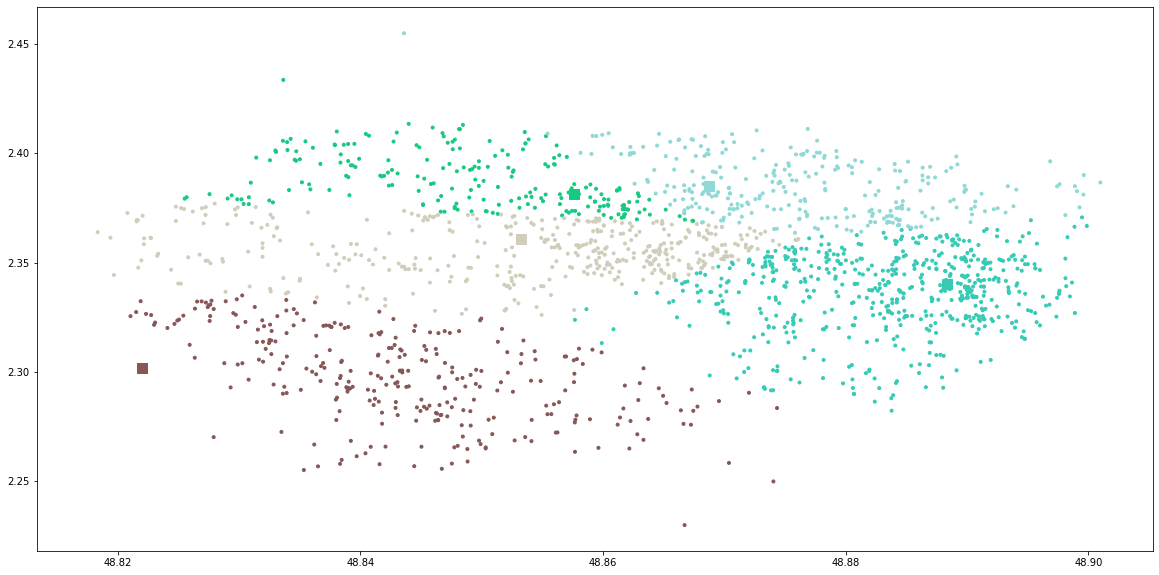

In [12]:
epsilon = 1e-5
#group = ['A','B','C','D']
group = ['A','B','C','D', 'E']
k = len(group)
colors = np.random.rand(k,3)

saves = []

for iteration in range(2000):
    centroids = rand_init(l_min, l_max, L_min, L_max, k) 
    distance_mat = get_distance_matrix(data_points, centroids, k)
    clusters = clusterize(data_points, distance_mat, k)
    score = get_score( clusters, centroids )

    centroids, clusters, score = repeat_until_good(score, centroids, data_points, k, eps= epsilon)
    saves.append( (score, centroids) )
    

best_score, best_centroids = min(saves, key = lambda t: t[0])

best_distance_mat = get_distance_matrix(data_points, best_centroids, k)
best_clusters = clusterize(data_points, best_distance_mat, k)


plt.figure(figsize=(20,10))
plt.scatter( [x[0] for x in best_centroids], [y[1] for y in best_centroids], c= colors, marker = 's', s=100)
for i in range(len(clusters)):
    plt.scatter( [x[0] for x in best_clusters[i]], [y[1] for y in best_clusters[i]], c= [colors[i]]*len(best_clusters[i]), marker='.')
    
best_score

In [13]:
distances = np.zeros(len(best_centroids))
likely_group = []
for ind, row in sample.iterrows():
    point = list(map(float,row["LOCATION"].split(",")))
    for i in range(len(best_centroids)):
        distances[i] = distance(point, best_centroids[i])
    id_grp = np.argmin(distances)
    likely_group.append( group[id_grp] )
    
sample["GROUP"] = likely_group
sample.head()

,TYPE,SUBTYPE,POSTAL_CODE,BOROUGH,YEAR,MONTH,NEIGHBORHOOD,LOCATION,GROUP
103247,Mobiliers urbains,"Protection:Potelet, barrière ou garde-corps dé...",75002,2,2018,6,GAILLON - VIVIENNE,"48.8679200014, 2.33231020355",A
345353,Propreté,Déchets et/ou salissures divers,75001,1,2017,11,LES HALLES,"48.8642473018, 2.34668340915",D
556969,Voirie et espace public,"Chaussées:Affaissement, trou, bosse, pavé arraché",75015,15,2018,2,GEORGES BRASSENS,"48.8287986078, 2.30407119277",C
301377,"Graffitis, tags, affiches et autocollants","Graffitis sur mur, façade sur rue, pont",75010,10,2018,1,SAINT-VINCENT DE PAUL - LARIBOISIERE,"48.8790148543, 2.35384397629",A
148022,Propreté,Déchets et/ou salissures divers,75020,20,2018,1,BELLEVILLE,"48.8725565165, 2.37902615778",E


look at each group most common vandalism type and deduce a demographic

In [14]:
groupA = sample[sample["GROUP"] == "A"]

print(groupA.shape)
groupA["TYPE"].value_counts() *100 / groupA["TYPE"].value_counts().sum()

(588, 9)


Propreté                                     39.625850
Graffitis, tags, affiches et autocollants    39.115646
Voirie et espace public                      13.095238
Mobiliers urbains                             5.102041
Autos, motos, vélos...                        3.061224
Name: TYPE, dtype: float64

In [15]:
groupB = sample[sample["GROUP"] == "B"]

print(groupB.shape)
groupB["TYPE"].value_counts() *100 / groupB["TYPE"].value_counts().sum()

(212, 9)


Graffitis, tags, affiches et autocollants    54.245283
Propreté                                     22.641509
Voirie et espace public                      10.377358
Autos, motos, vélos...                        6.603774
Mobiliers urbains                             6.132075
Name: TYPE, dtype: float64

In [16]:
groupC = sample[sample["GROUP"] == "C"]

print(groupC.shape)
groupC["TYPE"].value_counts() *100 / groupC["TYPE"].value_counts().sum()

(302, 9)


Propreté                                     38.741722
Graffitis, tags, affiches et autocollants    31.788079
Voirie et espace public                      17.549669
Autos, motos, vélos...                        6.953642
Mobiliers urbains                             4.966887
Name: TYPE, dtype: float64

In [17]:
groupD = sample[sample["GROUP"] == "D"]

print(groupD.shape)
groupD["TYPE"].value_counts() *100 / groupD["TYPE"].value_counts().sum()

(411, 9)


Graffitis, tags, affiches et autocollants    55.231144
Propreté                                     22.384428
Voirie et espace public                      13.868613
Autos, motos, vélos...                        4.379562
Mobiliers urbains                             4.136253
Name: TYPE, dtype: float64

In [18]:
groupE = sample[sample["GROUP"] == "E"]

print(groupE.shape)
groupE["TYPE"].value_counts() *100 / groupE["TYPE"].value_counts().sum()

(287, 9)


Graffitis, tags, affiches et autocollants    53.658537
Propreté                                     29.965157
Voirie et espace public                       6.271777
Mobiliers urbains                             5.226481
Autos, motos, vélos...                        4.878049
Name: TYPE, dtype: float64

Some categories seems very close, especially "Autos, motos, vélos..." and "Mobiliers urbains".  
We want to look if they are correlated, if it's the case we can group them as one class.  

In [62]:
from collections import Counter 

autos = sample[sample["TYPE"] == "Autos, motos, vélos..."]
mobil = sample[sample["TYPE"] == "Mobiliers urbains"]

autos_timeline = []
for time in autos[["YEAR", "MONTH"]].values.tolist():
    months = 0
    if(time[0] == 2019):
        months += 24
    elif(time[0] == 2018):
        months += 12
    months += time[1]
    autos_timeline.append(months)

mobil_timeline = []
for time in mobil[["YEAR", "MONTH"]].values.tolist():
    months = 0
    if(time[0] == 2019):
        months += 24
    elif(time[0] == 2018):
        months += 12
    months += time[1]
    mobil_timeline.append(months)
    
autos_timeline=  Counter(autos_timeline) 
mobil_timeline=  Counter(mobil_timeline)

max_x = max( max(autos_timeline), max(mobil_timeline) )
X = list(range(max_x))

autos_Y = []
mobil_Y = []

for i in X:
    autos_Y.append( autos_timeline[i] )
    mobil_Y.append( mobil_timeline[i] )
    

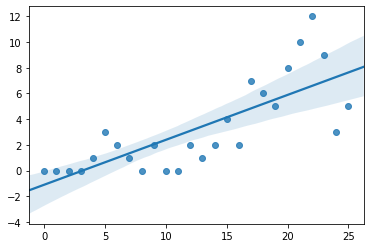

In [63]:
import seaborn as sns

sns.regplot(x= X, y=autos_Y)

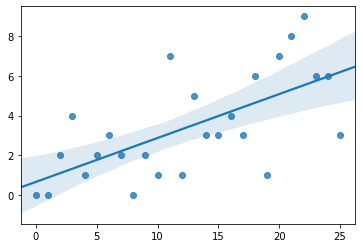

In [64]:
sns.regplot(x= X, y=mobil_Y)

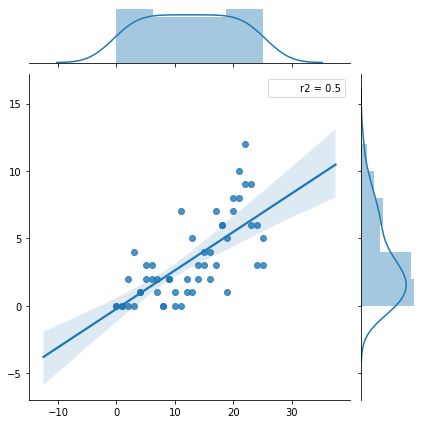

In [68]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

Y = autos_Y + mobil_Y
X2 = X + X

sns.jointplot(x= X2, y=Y, kind="reg", stat_func=r2)

Unfortunately, R2 = 0.5 is pretty weak to call out a correlation.  
We'll not continue on this idea.  
But we can note that both of these 2 type of vandalism raised steadily over the past 3 years.  
And we are talking from none to about 8 per month in one city.  

We can also see each categories as its own class, we can divide the dataframe and look at each class separately.  
One of the thing that i dislike in Paris is the amount of piss on the street, and it pisses me off. See what i did there ? 

Ok, we'll just focus on the type "Propreté". The methodology should be the same for the other types. 

In [69]:
#Foursquare credentials

CLIENT_ID = 'TIB5BOKHV15HM5FOTPBXEBZ5PYDHBQ5SD2P2DWAQAR2QNB1U' 
CLIENT_SECRET = 'SLXTUVU1MHMNKRMTAO1TR413FHAI1RLTT1CI4FMAHAAQOBRA'
VERSION = '20190804'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TIB5BOKHV15HM5FOTPBXEBZ5PYDHBQ5SD2P2DWAQAR2QNB1U
CLIENT_SECRET:SLXTUVU1MHMNKRMTAO1TR413FHAI1RLTT1CI4FMAHAAQOBRA


In [70]:
def type_of_venues(dataframe):
    venues = []
    for ind, row in dataframe.iterrows():
        cat = row["categories"]
        if(len(cat)==0):
            continue
        cat = cat[0]
        venues.append( cat["name"] )
    return venues



In [71]:
radius = 15

venues_list = []
venues_all = []

for ind, row in sample.iterrows():
    local = row["LOCATION"].split(',')
    local = list( map(float, local) )
    latitude = local[0]
    longitude = local[1]
    
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    results = requests.get(url).json()
    venues = results['response']['venues']
    dataframe = json_normalize(venues)
    
    venues_list.append(type_of_venues(dataframe))
    venues_all.extend(type_of_venues(dataframe))

    
    
sample["VENUES"] = venues_list
sample.head()

KeyboardInterrupt: 

In [ ]:
venues_all

In [134]:
from collections import Counter

most_common_venues = list(Counter(venues_all).most_common())
most_common_venues

[('French Restaurant', 171),
 ('Hotel', 134),
 ('Bar', 128),
 ('Bakery', 102),
 ('Café', 95),
 ('Office', 94),
 ('Plaza', 60),
 ('Bus Stop', 57),
 ('Italian Restaurant', 56),
 ('Residential Building (Apartment / Condo)', 52),
 ('Fast Food Restaurant', 47),
 ('Bistro', 45),
 ('Metro Station', 42),
 ('Restaurant', 40),
 ('Bike Rental / Bike Share', 40),
 ('Pizza Place', 34),
 ('Supermarket', 33),
 ('Bank', 29),
 ('Building', 29),
 ('Japanese Restaurant', 28),
 ('Asian Restaurant', 25),
 ('Coffee Shop', 24),
 ('Pharmacy', 23),
 ('Indian Restaurant', 23),
 ('Park', 22),
 ('Coworking Space', 21),
 ('Art Gallery', 21),
 ('Thai Restaurant', 21),
 ('Burger Joint', 20),
 ('Salon / Barbershop', 20),
 ('Garden', 20),
 ('Smoke Shop', 19),
 ('Wine Bar', 19),
 ('Sushi Restaurant', 18),
 ('Chinese Restaurant', 18),
 ('Pub', 18),
 ('Church', 18),
 ('Brasserie', 17),
 ('Sandwich Place', 17),
 ('Cocktail Bar', 16),
 ('Pedestrian Plaza', 16),
 ('African Restaurant', 16),
 ('Medical Center', 16),
 ('Tech 

In [ ]:
dissect per category of vandalism

In [ ]:
find correlation plot TYPE and near a type of VENUE per MONTH

## Results and Discussion <a name="results"></a>

## Conclusion <a name="conclusion"></a>

For starters, France could really use to have more public sanitaries by looking at the number of complaint for piss on public area.  



This dataset is completed by the crowd, there can be some noise, also not everybody care or know about it.  
A better dataset might give better results.  

Of course, it's not an exhaustive study, we've only used very little data and find crime correlation is more complex than what's been done here.  





Future direction can be to use genetic datasets to have a better prediction on ethnic hatred based crime.  
The ones such as 23andMe could offer that supposidly helps police to trace back to criminals.  
One usage would first override the ethnic censorship that takes place in France, where it's illegal to collect ethnic data. Keep in mind that whenever some French person say there's just 3% black or more 30%, he's probably bullshitting there's no data to support his claim. The only basis to these american-like claim are how we perceive our city, that's a weak claim indeed.  
The second we can highly reduce the number of suspects if somebody of the criminal's family gave their information. 